# How much emission are you REALLY responsible for.

In this notebook, we'll try to get an estimate of how much food-related emission a country is actually responsible for if we take into account the import and export streams. This analysis consists of three steps. First of all, we have to know the actual emissions of the country due to its agriculture. Secondly, we will calculate the amount of food that is traded between countries by analyzing the trade matrix. Thirdly, we will calculate the amount of food that is produced by a country. By then combining these three datasets, we can get an estimate of the extra emissions a country is to blame for by importing food or is absolved for, by exporting it.


# Milestone 2

## Table of contents
1. [Emissions](#emissions)
    1. [Introduction](#introduction)
    3. [Percentage of the worldly emission due to agriculture](#percentage_emissions)
    3. [Part of emission for meat/vegetal products](#world_meat_vegetal)
    4. [Emissions by Countries](#emissions_countries)
2. [Import and Export](#import_export)
    1. [Belgium](#belgium_trade)
    2. [Switzerland](#swiss_trade)
    3. [Comparison between Belgium and Switzerland](#comparison_belgium_swiss_trade)
    4. [Adding emissions](#adding_emissions)
3. [Production](#production)
    1. [Data Preparation](#prod_data_prep)
    2. [Analysis Production Data](#prod_data_ana)
4. [Combining all results](#combining)
5. [Conclusion](#conclusion)


## Emissions <a name="emissions"></a>

### Introduction <a name="introduction"></a>
In this section, we will present the data from a world-point of view, to get a feeling of what we're dealing with. This includes:
   - Visualising the percentage of emission due to agriculture
   - The part of emission in agriculture due to animal and vegetal products
   - The same as the previous point but by country.
   

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from matplotlib.ticker import MaxNLocator

import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *

In [2]:
# constants
DATA_PATH = '../data/'
GENERATED_DATA_PATH = '../generated/'
RESULT_PATH = '../results/'

### Percentage of worldly emission due to agriculture <a name="percentage_emissions"></a>

In this section we will use the Environment_Emissions_by_Sector_E_All_Data_(Normalized) dataset. More information on this dataset can be found <a href="http://www.fao.org/faostat/en/#data/EM"> here </a>. 

Our goal is to get a global view on the situation, and see how an important factor agriculture has been over the years.


In [3]:
# Load data and drop unnecessary columns
emissions_sector_path = DATA_PATH+'Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv'
emissions_sector = pd.read_csv(emissions_sector_path, encoding='latin-1', engine='python')
emissions_sector.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1990,1990,Gigagrams,943.2945,A
1,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1991,1991,Gigagrams,1022.1110,A
2,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1992,1992,Gigagrams,542.7868,A
3,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1993,1993,Gigagrams,548.8871,A
4,2,Afghanistan,6814,"Energy (energy, manufacturing and construction...",7231,Emissions (CO2eq),1994,1994,Gigagrams,537.9067,A


Emissions are expressed in <b>CO2eq units</b> (Carbon dioxide equivalent). CO2eq is a metric measure used to compare the emissions from various greenhouse gases on the basis of their global-warming potential (GWP), by converting amounts of other gases to the equivalent amount of carbon dioxide with the same global warming potential.

The <b>flags</b> represent the way the data is gathered (the full list can be found <a href="http://www.fao.org/faostat/en/#definitions"> here</a>).  

In [4]:
# Units
print(emissions_sector['Unit'].unique())
# Flags
emissions_sector.Flag.value_counts()

['Gigagrams' '%']


Fc    483973
A     336049
F        370
Name: Flag, dtype: int64

The flags represent : 
* `A` : Aggregate, may include official, semi-official, estimated or calculated data
* `Fc` : Calculated data
* `F` : FAO estimate

All these flag are acceptable, so we can then drop this column. From here on, we always implicitly check the flag values, but will not report it in this datastory (except if the flag represents unreliable data). 

Moreover, there is only one unit (Gigagrams), so we can drop this column aswell. 

In [5]:
# Drop unnecessary columns
emissions_sector.drop(columns=['Area Code', 'Item Code', 'Element Code', 'Year Code', 'Flag', 'Unit'], inplace=True)

In [6]:
# elements that are sum of other elements (found in the data META-file)
aggregates = ["Energy total", "Land Use total", "Sources total","Sources total excl. AFOLU"]

In [7]:
# We want CO2eq emission over the world for the different sectors over the years
emissions_sector_world = emissions_sector.loc[(emissions_sector['Area']=="World") & (emissions_sector['Element'] == "Emissions (CO2eq)")]
emissions_sector_world = emissions_sector_world.drop(columns=["Element","Area"])

# Pivot to make items into columns and clean
emissions = pd.pivot_table(emissions_sector_world, columns='Item', index=["Year"])
emissions.columns = emissions.columns.droplevel(0)
# Drop the aggregate values
emissions = emissions.drop(columns=aggregates)

emissions.rename(columns={'Energy (energy, manufacturing and construction industries and fugitive emissions)':'Energy'}, inplace=True)

In [211]:
# Create an interactive plot
data = emissions.unstack().reset_index().rename(columns = {0: 'Emissions (CO2eq)'})
data.Item = pd.Categorical(data.Item, 
                          categories=['Forest', 'Agriculture total', 'Energy',
                                       'Industrial processes and product use', 'International bunkers',
                                       'Land use sources', 'Other sources',
                                       'Residential, commercial, institutional and AFF', 'Transport',
                                       'Waste'],
                          ordered=True)
data = data.sort_values(by='Item')
data['Emissions (CO2eq)'] = data['Emissions (CO2eq)'].round(3)
fig = px.area(data, x="Year", y='Emissions (CO2eq)', color="Item")
offline.plot(fig, filename=RESULT_PATH+'graphs/emissions_sector.html', auto_open=False)

'../results/graphs/emissions_sector.html'

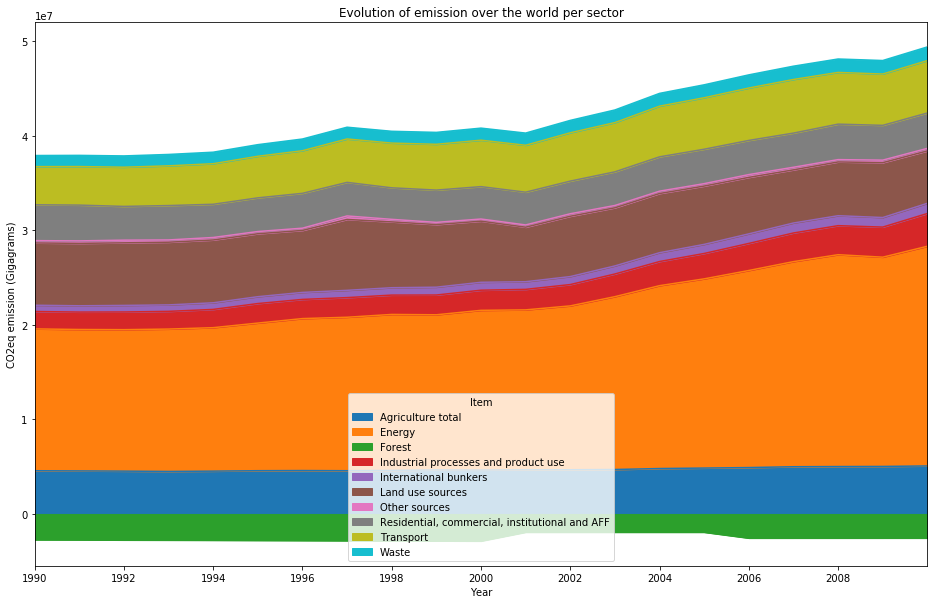

In [212]:
# Plot evolution of emission over the years
ax = emissions.plot.area()
fig = ax.get_figure()
fig.set_size_inches((16,10))
plt.title("Evolution of emission over the world per sector")
plt.ylabel("CO2eq emission (Gigagrams)")
ax.set_xticks(range(1990,2010,2))
plt.show()

As expected, we see that the worldy emission is rising (fast). Energy clearly makes up the biggest part, but agriculture also has a big influence.

Let's look at the percentages in 2010




In [9]:
emissions_sector_relative = emissions_sector.loc[(emissions_sector['Area'] == 'World') & (emissions_sector['Element'] == "Share of sector in total emissions") & (emissions_sector['Year'] == 2010)]
emissions_sector_relative = emissions_sector_relative.drop(columns=['Area', 'Element', 'Year']).sort_values(by='Value').round(2)
emissions_sector_relative

,Item,Value
696834,Other sources,0.54
697128,International bunkers,2.18
696540,Waste,2.93
696246,Industrial processes and product use,7.02
695952,"Residential, commercial, institutional and AFF",7.58
697422,Agriculture total,10.28
695658,Transport,11.22
697716,Land use sources,11.22
695364,"Energy (energy, manufacturing and construction...",47.04
698115,Energy total,65.84


Afolu means 'Agriculture, Forestry and Other Land Use' = 'Agriculture total' + 'Land use sources'

### Part of emissions for meat/vegetable <a name="world_meat_vegetal"></a>

Now that we know that agriculture makes up a remarkable part of greenhouse emissions, it is time to have a closes look. Many people give up eating meat for the climate, we will now investigate if this sacrifice is grounded. 

We will visualize the the part of emission in agriculture due to animal and vegetal products


In [214]:
# Load and clean data
emissions_total_path = DATA_PATH+'Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).csv'
emissions_total = pd.read_csv(emissions_total_path, encoding='latin-1', engine='python')
emissions_total = emissions_total.drop(columns=['Item Code', 'Element Code', 'Area Code', 'Year Code', 'Unit', 'Note', 'Flag'])

In [215]:
vegetal_emissions = ['Rice Cultivation', 'Synthetic Fertilizers', 'Manure applied to Soils', 'Crop Residues',
       'Cultivation of Organic Soils', 'Burning - Crop residues']
animal_emissions = ['Enteric Fermentation', 'Manure Management', 'Manure left on Pasture']

In [216]:
# We're only interested in the world data, and total emission
emissions_world = emissions_total.loc[(emissions_total['Area'] == 'World') & (emissions_total['Element'] == "Emissions (CO2eq)")]
emissions_world = emissions_world.drop(columns=['Area', 'Element'])

In [217]:
# Pivot the table to make element columns
emissions_world = pd.pivot_table(emissions_world, values='Value', index=['Year'], columns='Item')

In [218]:
# Let us have a quick look at the data
emissions_world

Item,Agricultural Soils,Agriculture total,Burning - Crop residues,Burning - Savanna,Crop Residues,Cultivation of Organic Soils,Enteric Fermentation,Manure Management,Manure applied to Soils,Manure left on Pasture,Rice Cultivation,Synthetic Fertilizers
Year,,,,,,,,,,,,
1961,7.423140e+05,2.751474e+06,20108.5834,NaN,84002.9553,NaN,1.372453e+06,250642.7499,127533.0080,4.559833e+05,365955.9325,74794.7749
1962,7.653188e+05,2.813011e+06,20233.7001,NaN,87863.9442,NaN,1.392502e+06,255847.4235,130164.1889,4.624951e+05,379109.0457,84795.5791
1963,7.836215e+05,2.849990e+06,20606.5104,NaN,88609.4599,NaN,1.407395e+06,258903.1345,131989.3153,4.677551e+05,379464.1001,95267.6498
1964,8.078094e+05,2.910094e+06,21119.8990,NaN,92894.6728,NaN,1.426616e+06,259543.8939,131372.4133,4.772082e+05,395004.9947,106334.1092
1965,8.379904e+05,2.971073e+06,21068.5649,NaN,92395.2622,NaN,1.453232e+06,264343.3867,134337.6366,4.879906e+05,394438.5363,123266.8707
1966,8.752929e+05,3.050038e+06,21435.8203,NaN,97648.0284,NaN,1.484941e+06,268016.1712,137986.2226,4.964990e+05,400351.9645,143159.6411
1967,9.054521e+05,3.121375e+06,21714.4552,NaN,100340.8951,NaN,1.514403e+06,275698.1244,141471.7620,5.073750e+05,404107.2079,156264.4185
1968,9.329120e+05,3.180822e+06,21870.0393,NaN,103423.8136,NaN,1.536975e+06,278263.7699,142494.8551,5.175750e+05,410800.6903,169418.3094
1969,9.526092e+05,3.211459e+06,21724.1911,NaN,103616.0835,NaN,1.544102e+06,277955.6862,142525.0221,5.226995e+05,415067.8733,183768.5941


We can see that our data contains NaN values for 'Burning Savanna' and 'Cultivation of Organic Soils'. Is this just in the world data, or is there no data available at all? 

In [219]:
print(emissions_total.loc[(emissions_total['Item'] == "Burning - Savanna")].Year.unique())
print(emissions_total.loc[(emissions_total['Item'] == "Cultivation of Organic Soils")].Year.unique())

[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2030 2050]
[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2030 2050]


There is no data available before 1990 (but we can assume that there was emission from these factors before that year. We will continue from the year 1990.

In [220]:
emissions_world = emissions_world[~emissions_world.isna().any(axis=1)]

In [221]:
%%capture
# Group by animal and vegetal
emissions_world['Animal'] = emissions_world[animal_emissions].sum(axis=1)
emissions_world['Vegetal'] = emissions_world[vegetal_emissions].sum(axis=1)
emissions_world = emissions_world[['Animal', 'Vegetal']]
emissions_world = emissions_world.loc[:2017]

In [223]:
# Plot interactive graph
data = emissions_world.unstack().reset_index().rename(columns = {0: 'Emissions (CO2eq)'})
fig = px.area(data, x="Year", y='Emissions (CO2eq)', color="Item")
offline.plot(fig, filename=RESULT_PATH+'graphs/emissions_world.html', auto_open=False)

'../results/graphs/emissions_world.html'

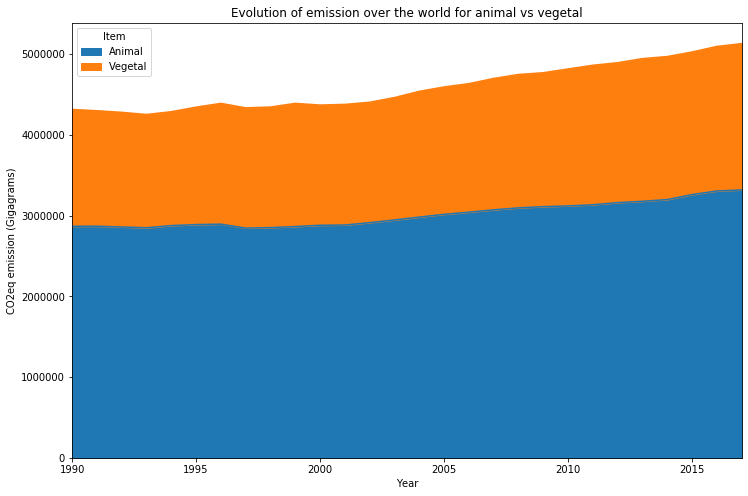

In [224]:
# Plot evolution of emission over the years (includes predictions for 2030 and 2050)
ax = emissions_world.plot.area()
fig = ax.get_figure()
fig.set_size_inches((12,8))
plt.title("Evolution of emission over the world for animal vs vegetal")
plt.ylabel("CO2eq emission (Gigagrams)")
plt.show()

We clearly see that Animal emission is a bigger influence than Vegetal emission (more than double). Moreover, we have not yet considered the fact that many vegetable products are used as fodder. 

Would humanity prosper by focussing more on vegetal products? The rest of our investigation will shed more light on this.

### Emission By countries <a name="emissions_countries"></a>

After studying the emissions in their globality we will focus on the emissions by countries.

In [19]:
# Filter only Emmisions (CO2eq)
print(emissions_total.shape)
emissions_total.head()

(517655, 5)


,Area,Item,Element,Year,Value
0,Afghanistan,Enteric Fermentation,Emissions (CH4),1961,240.6831
1,Afghanistan,Enteric Fermentation,Emissions (CH4),1962,245.3106
2,Afghanistan,Enteric Fermentation,Emissions (CH4),1963,255.8285
3,Afghanistan,Enteric Fermentation,Emissions (CH4),1964,259.0650
4,Afghanistan,Enteric Fermentation,Emissions (CH4),1965,265.5980


First, we have to investigate the countries to remove aggragated countries.

In [20]:
emissions_total.Area.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belgium-Luxembourg', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia (Plurinational State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, mainland', 'China, Taiwan Province of', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire",
       'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia',
       "Democratic People's Republic of Korea",
       'Democratic Re

In [21]:
# Remove aggregation item
agg_item = ['Agriculture total', 'Agricultural Soils']
emissions_total = emissions_total.drop(emissions_total[emissions_total['Item'].isin(agg_item)].index)

# Remove aggregation countries
# We remove China as we have different data for Hong kong, Tawain, Macao and the Mainland
agg_country = ['Belgium-Luxembourg', 'China', 'Yugoslav SFR','World', 'Africa',
       'Eastern Africa', 'Middle Africa', 'Northern Africa',
       'Southern Africa', 'Western Africa', 'Americas',
       'Northern America', 'Central America', 'Caribbean',
       'South America', 'Asia', 'Central Asia', 'Eastern Asia',
       'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Oceania', 'Australia and New Zealand',
       'Melanesia', 'Micronesia', 'Polynesia', 'European Union',
       'Least Developed Countries', 'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries', 'Annex I countries',
       'Non-Annex I countries', 'OECD']
emissions_total = emissions_total.drop(emissions_total[emissions_total['Area'].isin(agg_country)].index)
emissions_total = emissions_total.rename(columns={'Area':'Country'})

# Keep only past data
emissions_total = emissions_total[(emissions_total.Year < 2019)]

In [22]:
emissions_total

,Country,Item,Element,Year,Value
0,Afghanistan,Enteric Fermentation,Emissions (CH4),1961,240.6831
1,Afghanistan,Enteric Fermentation,Emissions (CH4),1962,245.3106
2,Afghanistan,Enteric Fermentation,Emissions (CH4),1963,255.8285
3,Afghanistan,Enteric Fermentation,Emissions (CH4),1964,259.0650
4,Afghanistan,Enteric Fermentation,Emissions (CH4),1965,265.5980
...,...,...,...,...,...
433705,Zimbabwe,Burning - Savanna,Emissions (N2O),2013,3.8549
433706,Zimbabwe,Burning - Savanna,Emissions (N2O),2014,4.2697
433707,Zimbabwe,Burning - Savanna,Emissions (N2O),2015,5.1211
433708,Zimbabwe,Burning - Savanna,Emissions (N2O),2016,3.0542


In [23]:
# In 2011, Sudan (former) split into two countries: Sudan and South Sudan. We will just assume one united Sudan and merge them.
emissions_total.loc[(emissions_total['Country']=='Sudan') & (emissions_total['Year']>2011), 'Value'] += emissions_total.loc[(emissions_total['Country']=='South Sudan') & (emissions_total['Year']>2011), 'Value'] 
emissions_total.loc[(emissions_total['Country']=='Sudan (former)', 'Country')] = 'Sudan'
emissions_total= emissions_total[emissions_total['Country'] != 'South Sudan']

Russia also poses a problem, as it only exists from 1992. Before, Russia and many other countries formed the USSR together.
As it is too complicated to split this up, we will just keep this data as original.

In [24]:
# Pivot the table to make element columns
emissions_total = pd.pivot_table(emissions_total, values='Value', index=['Country', 'Year'], columns='Item')
emissions_total.head()

Item              Burning - Crop residues  Burning - Savanna  Crop Residues  \
Country     Year                                                              
Afghanistan 1961                 48.14768                NaN     222.191933   
            1962                 49.56468                NaN     223.887467   
            1963                 49.56468                NaN     208.833033   
            1964                 49.95084                NaN     225.216933   
            1965                 49.82096                NaN     227.653600   

Item              Cultivation of Organic Soils  Enteric Fermentation  \
Country     Year                                                       
Afghanistan 1961                           NaN           3449.791633   
            1962                           NaN           3516.118733   
            1963                           NaN           3666.875433   
            1964                           NaN           3713.265000   
            1965                           NaN           3806.904667   

Item              Manure Management  Manure applied to Soils  \
Country     Year                                               
Afghanistan 1961          149.53680               260.714567   
            1962          153.04790               264.428667   
            1963          159.63620               271.603167   
            1964          162.58858               277.219600   
            1965          168.10418               285.631033   

Item              Manure left on Pasture  Rice Cultivation  \
Country     Year                                             
Afghanistan 1961             1581.328700        421.400000   
            1962             1553.267767        421.400000   
            1963             1596.084133        421.400000   
            1964             1617.861800        441.466667   
            1965             1657.354567        441.466667   

Item              Synthetic Fertilizers  
Country     Year                         
Afghanistan 1961                   4.31  
            1962                   4.31  
            1963                   4.31  
            1964                   4.31  
            1965                   4.31

In [25]:
# Here we assume that if there is no data the country just did not produce any emission of that type
emissions_total.fillna(0, inplace=True)

We will now divide the emissions between animal and vegetal emissions

In [26]:
emissions_total['Animal'] = emissions_total[animal_emissions].sum(axis=1)
emissions_total['Vegetal'] = emissions_total[vegetal_emissions].sum(axis=1)
emissions_total = emissions_total[['Animal', 'Vegetal']]

In [27]:
# Create a new column sum
emissions_total['Sum'] = emissions_total.sum(axis=1)
emissions_total.head()

Item                   Animal      Vegetal          Sum
Country     Year                                       
Afghanistan 1961  5180.657133   956.764180  6137.421313
            1962  5222.434400   963.590813  6186.025213
            1963  5422.595767   955.710880  6378.306647
            1964  5493.715380   998.164040  6491.879420
            1965  5632.363413  1008.882260  6641.245673

In [28]:
# create a new dataframe with relative numbers
relative_emissions_total = pd.DataFrame()
for col in emissions_total.columns:
    new_col = '% '+col
    relative_emissions_total[new_col] = emissions_total[col]/emissions_total['Sum'] * 100
    
relative_emissions_total.head()

% Animal  % Vegetal  % Sum
Country     Year                             
Afghanistan 1961  84.410974  15.589026  100.0
            1962  84.423102  15.576898  100.0
            1963  85.016229  14.983771  100.0
            1964  84.624421  15.375579  100.0
            1965  84.808840  15.191160  100.0

In [29]:
# Save the datasets for later use
emissions_total.to_csv(GENERATED_DATA_PATH+'emissions_total.csv')
relative_emissions_total.to_csv(GENERATED_DATA_PATH+'relative_emissions_total.csv')

#### EDA

We will now look at the descriptive statistics of the emission total data frame.

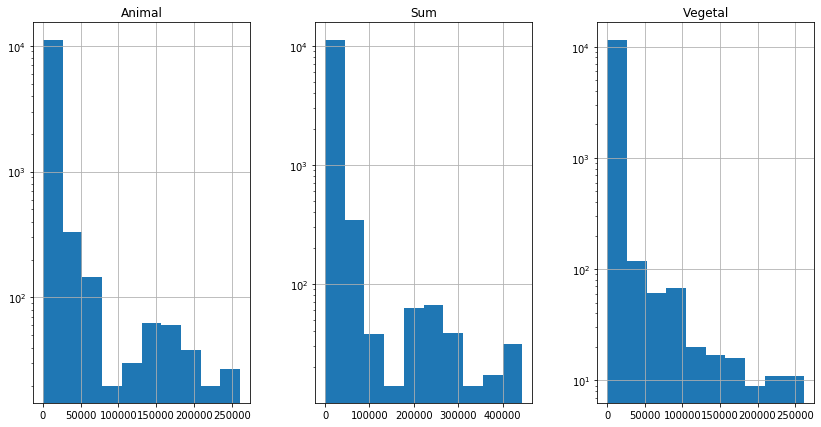

In [30]:
emissions_total.hist(figsize=(14,7), log=True, layout=(1,3))
plt.show()

The distribution seems to follow an exponential law. Indeed, if we look at the higher entry we see that it corresponds to the most populated country in the world (China) for the last years.

In [31]:
emissions_total['Sum'].sort_values(ascending=False).head(10)

Country          Year
China, mainland  2016    444373.463500
                 2015    442483.968093
                 2017    436156.198520
                 2014    435982.920227
                 2013    434647.288000
                 2012    432895.890900
                 2010    431570.527287
                 2011    431304.736207
                 1996    428703.425400
                 2009    425140.160640
Name: Sum, dtype: float64

To balance this bias introduced by the number of habitants we will divide all the emissions by the number of people to obtain the emission per capita. The population information is available in the Population_E_All_Data_(Normalized).csv dataset.

In [32]:
population = pd.read_csv(DATA_PATH+'Population_E_All_Data_(Normalized).csv',  encoding='latin-1', engine='python')
print(population.shape)
population.head()

(160411, 12)


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1950,1950,1000 persons,7752.118,X,NaN
1,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1951,1951,1000 persons,7840.156,X,NaN
2,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1952,1952,1000 persons,7935.997,X,NaN
3,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1953,1953,1000 persons,8039.694,X,NaN
4,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1954,1954,1000 persons,8151.317,X,NaN


We need to clean the dataset

In [183]:
population = population[population['Element'] == 'Total Population - Both sexes']
population = population.drop(columns = ['Area Code', 'Item Code', 'Item', 'Element Code', 'Element', 'Year Code', 'Unit', 'Flag', 'Note'])
population = population.rename(columns={'Area':'Country', 'Value':'Population'})

# We also apply the transformation from Sudan (former) to Sudan 
population.loc[(population['Country']=='Sudan') & (population['Year']>2011), 'Population'] += population.loc[(population['Country']=='South Sudan') & (population['Year']>2011), 'Population'] 
population.loc[(population['Country']=='Sudan (former)', 'Country')] = 'Sudan'
population = population[population['Country'] != 'South Sudan']

#population.loc[population[population['Country'] == 'USSR'].index,'Country'] = 'Russian Federation'

# Set Country + Year as index
population = population.set_index(['Country', 'Year'])
print(population.shape)
# we have to multiply the value of popluation by 1000 because the unit was 1000 people
population['Population'] *= 1000
population.head()

(39352, 1)


Population
Country     Year            
Afghanistan 1950   7752118.0
            1951   7840156.0
            1952   7935997.0
            1953   8039694.0
            1954   8151317.0

In [34]:
# We can now make a join with the emission dataset
emissions_total_population = pd.merge(emissions_total, population, left_index=True, right_index=True).sort_index()
emissions_total_population.head()

Animal      Vegetal          Sum  Population
Country     Year                                                   
Afghanistan 1961  5180.657133   956.764180  6137.421313   9169410.0
            1962  5222.434400   963.590813  6186.025213   9351441.0
            1963  5422.595767   955.710880  6378.306647   9543205.0
            1964  5493.715380   998.164040  6491.879420   9744781.0
            1965  5632.363413  1008.882260  6641.245673   9956320.0

Finally we can divide the columns Animal, Vegetal and Sum by the population to obtain the emission per capita. We multiply by
$10^6$
to receive the emission per capita in kilogram of CO2eq.


In [35]:
emissions_per_capita = pd.DataFrame()
for col in ['Animal', 'Vegetal', 'Sum']:
    emissions_per_capita[col] = emissions_total_population[col] / emissions_total_population['Population'] * 1e6
emissions_per_capita.head()

Animal     Vegetal         Sum
Country     Year                                    
Afghanistan 1961  564.993509  104.343047  669.336556
            1962  558.463065  103.041960  661.505025
            1963  568.215371  100.145693  668.361064
            1964  563.759758  102.430628  666.190386
            1965  565.707351  101.330839  667.038190

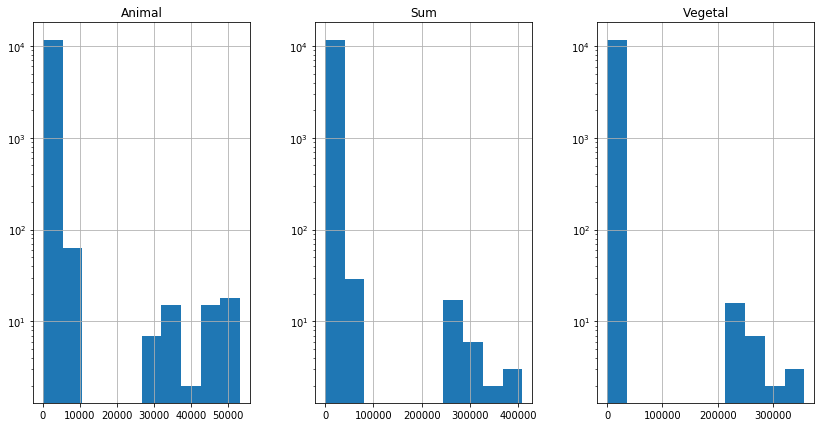

In [36]:
emissions_per_capita.hist(figsize=(14,7), log=True, layout=(1,3))
plt.show()

It seems to have outliers. Let's look at them. 

In [37]:
emissions_per_capita[emissions_per_capita['Animal'] > 40000]

Animal        Vegetal            Sum
Country                     Year                                            
Falkland Islands (Malvinas) 1961  43684.590781      88.225149   43772.815930
                            1962  43764.335224      88.327032   43852.662256
                            1963  45116.677730      88.904694   45205.582425
                            1964  45066.736943      90.001597   45156.738540
                            1965  45282.733397      91.033045   45373.766442
                            1966  45489.935212      92.500810   45582.436022
                            1967  46545.702574      94.261354   46639.963929
                            1968  46232.129309      94.425202   46326.554511
                            1969  46672.428476      95.093147   46767.521623
                            1970  47304.491299      95.431727   47399.923025
                            1971  48377.616862      96.294408   48473.911270
                            1972  48024.036791      95.230795   48119.267586
                            1973  46768.516598      96.109959   46864.626556
                            1974  47850.017325      96.067221   47946.084546
                            1975  49613.554037      97.127343   49710.681380
                            1976  49947.467796      97.494265   50044.962061
                            1977  49657.162138      98.437223   49755.599361
                            1978  50313.699947     115.038263   50428.738210
                            1979  50984.048772     132.365071   51116.413843
                            1980  51369.773463     141.477886   51511.251348
                            1981  50671.545684     159.263272   50830.808956
                            1982  51338.938820     167.677315   51506.616134
                            1983  51882.476915     181.386927   52063.863842
                            1984  52236.334417     195.287107   52431.621524
                            1985  53140.241441     198.558559   53338.800000
                            1986  53292.212040     191.931716   53484.143756
                            1987  51669.595149     163.813091   51833.408240
                            1988  51780.863741     156.953993   51937.817733
                            1989  53388.387766     149.092794   53537.480560
                            1990  51361.564077  356975.260679  408336.824756
                            1991  48447.261270  342954.968492  391402.229762
                            1992  45199.083333  327546.172840  372745.256173
                            1993  43313.637961  310845.093732  354158.731693
                            1994  41558.454025  296173.670992  337732.125017

In [38]:
emissions_total_population.loc['Falkland Islands (Malvinas)'].head()

,Animal,Vegetal,Sum,Population
Year,,,,
1961,92.873440,0.187567,93.061007,2126.0
1962,92.605333,0.186900,92.792233,2116.0
1963,95.151073,0.187500,95.338573,2109.0
1964,94.054280,0.187833,94.242113,2087.0
1965,94.097520,0.189167,94.286687,2078.0


We see that the outliers are caused by one country `Falkland Islands (Malvinas)`. The emission seems not so big on absolute, however, the island is only populated by 2000 people (the data contained in the dataset is correct, we have checked). Furthermore the island (which has the 5th highest Gross Product per Capita) is known for its industry of sheep farming. This explains that the emission coming from animals is the biggest one per capita. For now let us remove that country because even if the data is correct, we want to focus on larger countries and this particular casecan be neglected.



In [39]:
emissions_per_capita = emissions_per_capita.drop(index='Falkland Islands (Malvinas)')

We will now take the mean of the emissions for each country over the years in order to see which are the one who emits the most per capita.

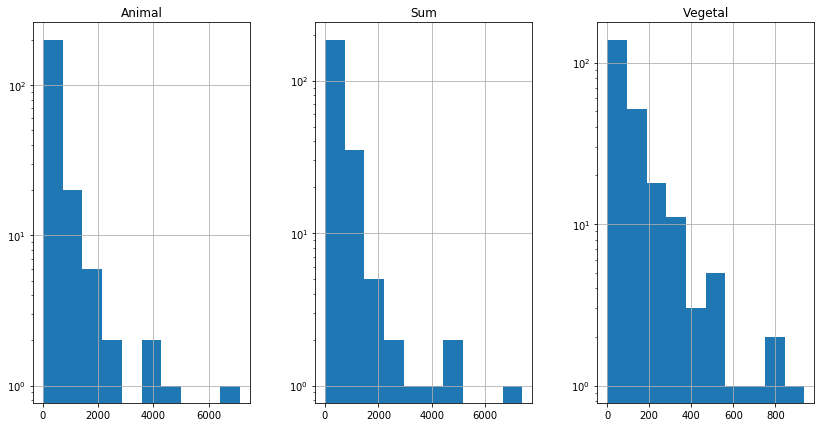

In [40]:
emissions_per_capita = emissions_per_capita.groupby(level=[0]).mean()
emissions_per_capita.hist(figsize=(14,7), log=True, layout=(1,3))
plt.show()

In [41]:
emissions_per_capita['Sum'].sort_values(ascending=False).head(10)

Country
New Zealand    7398.001096
Uruguay        4895.881623
Mongolia       4451.474875
Australia      4254.650018
Ireland        3270.815460
Paraguay       2346.861893
Argentina      2283.933067
Namibia        2065.345131
Somalia        1980.118501
Mauritania     1912.174699
Name: Sum, dtype: float64

In [42]:
emissions_per_capita['Animal'].sort_values(ascending=False).head(10)

Country
New Zealand    7143.584276
Uruguay        4610.856385
Australia      3975.826568
Mongolia       3677.255598
Ireland        2467.894539
Paraguay       2237.799988
Argentina      2126.091030
Namibia        2041.993702
Somalia        1958.589988
Mauritania     1870.103299
Name: Animal, dtype: float64

In [43]:
emissions_per_capita['Vegetal'].sort_values(ascending=False).head(10)

Country
Guyana       937.373270
Ireland      802.920921
Mongolia     774.219277
Belarus      706.612933
Suriname     653.400795
Cambodia     518.019752
Estonia      507.796001
Lithuania    507.333401
Thailand     494.949061
Denmark      483.404868
Name: Vegetal, dtype: float64

These country are not necessarily the ones we expected. Indeed we do not see China or India.
That's because this dataset focus on emission due to agriculture. Moreover we can see that the top 10 emitters are the same (almost in the same order) if we look at the total emsissions and the emsissions du to animal products. These countries are known for producing a lot of meat. It could be interesting to look at their emission when we have will consider the importations and exportations.

## Import and Export <a name="import_export"></a>
Now, we will focus our main analysis on comparing emissions between Belgium and Switzerland (as we are all exchange students from Belgium). This we will do for both vegetal and animal products.

A shortcoming of the data presented in the introduction is that it does not take into account the importation/exportation of the country.
We will use the `detailed trade matrix` dataset to improve our results by adding emission due to the production of imported procucts and removing emission for exportation products.

We will then compare the results between Belgium and Switzerland to figure out which country is responsible for the most emission.

First - because the trade dataset is huge - we will only select rows concerning Belgium, and then export the dataset to pandas to create a new csv file.

In [44]:
conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [45]:
trades = spark.read.csv(DATA_PATH+'Trade_DetailedTradeMatrix_E_All_Data_(Normalized).csv', header =True)

In [46]:
trades.printSchema()

root
 |-- Reporter Country Code: string (nullable = true)
 |-- Reporter Countries: string (nullable = true)
 |-- Partner Country Code: string (nullable = true)
 |-- Partner Countries: string (nullable = true)
 |-- Item Code: string (nullable = true)
 |-- Item: string (nullable = true)
 |-- Element Code: string (nullable = true)
 |-- Element: string (nullable = true)
 |-- Year Code: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Flag: string (nullable = true)



In [47]:
trades = trades.withColumnRenamed('Reporter Countries', 'Countries')

### Belgium <a name="belgium_trade"></a>

We will first study the trade of belgium

In [48]:
trades.registerTempTable("Trades")

query = """
SELECT *
FROM Trades
WHERE Countries = 'Belgium'
"""

belgium_trade = spark.sql(query)
belgium_trade.show(5)

+---------------------+---------+--------------------+-----------------+---------+---------------+------------+---------------+---------+----+--------+--------+----+
|Reporter Country Code|Countries|Partner Country Code|Partner Countries|Item Code|           Item|Element Code|        Element|Year Code|Year|    Unit|   Value|Flag|
+---------------------+---------+--------------------+-----------------+---------+---------------+------------+---------------+---------+----+--------+--------+----+
|                  255|  Belgium|                   2|      Afghanistan|      231|Almonds shelled|        5610|Import Quantity|     2015|2015|  tonnes|0.000000|null|
|                  255|  Belgium|                   2|      Afghanistan|      231|Almonds shelled|        5610|Import Quantity|     2016|2016|  tonnes|1.000000|null|
|                  255|  Belgium|                   2|      Afghanistan|      231|Almonds shelled|        5610|Import Quantity|     2017|2017|  tonnes|1.000000|null|
|   

In [49]:
belgium_trade_df = belgium_trade.toPandas()

In [50]:
belgium_trade_df.to_csv(GENERATED_DATA_PATH+'trade_belgium.csv')

<b> From now we can start from this cell. </b>

In [51]:
belgium_trade_df = pd.read_csv(GENERATED_DATA_PATH+'trade_belgium.csv', index_col=0)

In [52]:
belgium_trade_df.head()

,Reporter Country Code,Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,255,Belgium,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2015,2015,tonnes,0.0,NaN
1,255,Belgium,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2016,2016,tonnes,1.0,NaN
2,255,Belgium,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2017,2017,tonnes,1.0,NaN
3,255,Belgium,2,Afghanistan,231,Almonds shelled,5622,Import Value,2015,2015,1000 US$,0.0,NaN
4,255,Belgium,2,Afghanistan,231,Almonds shelled,5622,Import Value,2016,2016,1000 US$,4.0,NaN


In [53]:
# Get rid of useless columns and rename `Partner Countries`
belgium_trade_df = belgium_trade_df.drop(columns=['Reporter Country Code', 'Countries', 'Partner Country Code', 'Item Code', 'Element Code', 'Year Code', 'Unit', 'Flag'])
belgium_trade_df = belgium_trade_df.rename(columns={'Partner Countries': 'Country'})

In [54]:
with open(os.path.join(DATA_PATH, "item_classifications.json"), "r") as f:
    classifications = json.load(f)

In [55]:
animal_item = pd.Series()
for t, items in classifications['Animals'].items():
    animal_item = animal_item.append(pd.Series({int(x): 1 for x in items}))
print(animal_item)

882     1
951     1
982     1
1020    1
1130    1
1062    1
1091    1
867     1
868     1
870     1
947     1
948     1
977     1
978     1
1017    1
1018    1
1035    1
1036    1
1038    1
1058    1
1059    1
1069    1
1075    1
1073    1
1074    1
1080    1
1081    1
1089    1
1097    1
1098    1
1108    1
1111    1
1127    1
1128    1
1141    1
1151    1
1158    1
1160    1
1163    1
1176    1
1166    1
1167    1
dtype: int64


In [56]:
belgium_trade_df

,Country,Item,Element,Year,Value
0,Afghanistan,Almonds shelled,Import Quantity,2015,0.0
1,Afghanistan,Almonds shelled,Import Quantity,2016,1.0
2,Afghanistan,Almonds shelled,Import Quantity,2017,1.0
3,Afghanistan,Almonds shelled,Import Value,2015,0.0
4,Afghanistan,Almonds shelled,Import Value,2016,4.0
...,...,...,...,...,...
628128,Zimbabwe,Wine,Export Value,2008,4.0
628129,Zimbabwe,Wine,Export Value,2012,1.0
628130,Zimbabwe,Wine,Export Value,2013,1.0
628131,Zimbabwe,Wine,Export Value,2014,2.0


We will separate this dataset into 2: one for the trading of animal products and the other for the vegetable products. The lists of animal items and vegetable item are in the `anim_items_trade.txt` and `veg_items_trade.txt` and have been done by hand.

In [57]:


animal_item = pd.read_csv(DATA_PATH+'anim_item_trade.csv')
animal_item = animal_item.rename(columns={'Unnamed: 0': 'Item'})
animal_item.head()

,Item,Factor
0,Animals live nes,1
1,"Animals, live, non-food",1
2,Asses,1
3,Bacon and ham,1
4,Beehives,1


In [149]:
belgium_animal_trade = pd.merge(belgium_trade_df, animal_item, left_on='Item', right_on='Item')
belgium_animal_trade['Corrected Value'] = belgium_animal_trade.Value * belgium_animal_trade.Factor
belgium_animal_trade = belgium_animal_trade.drop(columns=['Item', 'Value', 'Factor'])
belgium_animal_trade = belgium_animal_trade.rename(columns={'Corrected Value': 'Value'})
belgium_animal_trade.head()

,Country,Element,Year,Value
0,Afghanistan,Export Value,2008,14.0
1,Afghanistan,Export Value,2009,9.0
2,Afghanistan,Export Value,2017,34.0
3,Albania,Export Value,2005,4.0
4,Albania,Export Value,2008,2.0


In [150]:
belgium_animal_trade.Element.unique()

array(['Export Value', 'Import Value', 'Export Quantity',
       'Import Quantity'], dtype=object)

In [151]:
# Get only the export and import quantity
belgium_animal_trade = belgium_animal_trade[belgium_animal_trade.Element.isin(['Export Quantity', 'Import Quantity'])]

In [153]:
# Pivot the table
belgium_animal_trade = pd.pivot_table(belgium_animal_trade, values='Value', index=['Country', 'Year'], columns='Element')
belgium_animal_trade.head()

Element           Export Quantity  Import Quantity
Country     Year                                  
Afghanistan 2003        22.000000              NaN
            2004         0.000000              NaN
            2005         1.166667              NaN
            2006        14.000000              NaN
            2007        25.000000              NaN

In [157]:
belgium_animal_trade.isnull().sum()[belgium_animal_trade.isnull().sum() != 0]

Series([], dtype: int64)

If we have NaN values, we will assume Belgium did not trade with the country in that year. We fill them with 0

In [158]:
belgium_animal_trade = belgium_animal_trade.fillna(value=0)

We will compute the net importation/exportation quantity between a country and belgium

In [159]:
belgium_animal_trade['Net Quantity'] = belgium_animal_trade['Import Quantity'] - belgium_animal_trade['Export Quantity']

We only have information about the 21st century

In [160]:
belgium_animal_trade.index.levels[1]

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='Year')

We will do the same with the vegetable products

In [161]:
vegetable_item = pd.read_csv(DATA_PATH+'veg_items_trade.csv')
vegetable_item = vegetable_item.rename(columns={'Unnamed: 0': 'Item'})


def clean_trade_data(country_trade, item_df):
    # Keep animal or vegetable items
    trade = pd.merge(country_trade, item_df, left_on='Item', right_on='Item')
    trade['Corrected Value'] = trade.Value * trade.Factor
    trade = trade.drop(columns=['Item', 'Value', 'Factor'])
    trade = trade.rename(columns={'Corrected Value': 'Value'})
    trade = trade[trade.Element.isin(['Export Quantity', 'Import Quantity'])]
    # Keep data from 2000 and after
    trade = trade[trade.Year >= 2000]
    # Pivot the table
    trade = pd.pivot_table(trade, values='Value', index=['Country', 'Year'], columns='Element')
    # Fill NaN
    trade.fillna(value=0, inplace=True)
    # Compute the Net Quantity
    trade['Net Quantity'] = trade['Import Quantity'] - trade['Export Quantity']
    # Fill the missing years with 0's
    new_data = pd.DataFrame()
    for col in trade.columns:
        new_data[col] = trade[col].unstack().fillna(value=0).stack()
    trade = new_data
    return trade

belgium_vegetable_trade = clean_trade_data(belgium_trade_df, vegetable_item)
belgium_vegetable_trade.head()

Export Quantity  Import Quantity  Net Quantity
Country     Year                                                
Afghanistan 2000          8154.50              0.0      -8154.50
            2001          1014.00              0.0      -1014.00
            2002           151.40              0.0       -151.40
            2003           373.00              0.0       -373.00
            2004           710.25              0.0       -710.25

We will now look at the evolution of the total net quantity traded by belgium from 2000 to 2017 for animal products and vegetable products.

In [170]:
total_animal_product.index

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='Year')

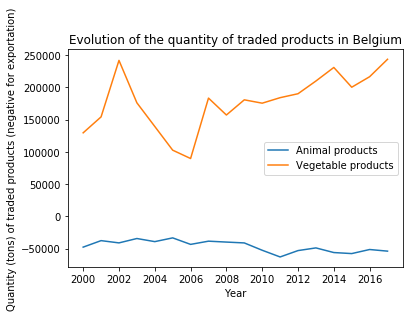

In [174]:
total_animal_product = belgium_animal_trade.groupby(level=1).sum()['Net Quantity']
total_vegetable_product = belgium_vegetable_trade.groupby(level=1).sum()['Net Quantity']

fig = plt.figure()
plt.plot(total_animal_product.index, total_animal_product, label='Animal products')
plt.plot(total_animal_product.index, total_vegetable_product, label='Vegetable products')
# Set x label as integer
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Evolution of the quantity of traded products in Belgium")
plt.ylabel("Quantity (tons) of traded products (negative for exportation)")
plt.xlabel("Year")
plt.legend()
plt.show()

We can see that Belgium exports more animal product than it imports and that the quantity of exported animal product is relatively constant while Belgium imports much more vegetable products (one part of these vegetable product are used to feed the livestock). Moreover the importation of vegetable product has grown in the past few years.

### Switzerland <a name="swiss_trade"></a>

We will do the same job for switzerland.
We first neeed to extract data related to switzerland in the detailed trade matrix

In [68]:
trades.registerTempTable("Trades")

query = """
SELECT *
FROM Trades
WHERE Countries = 'Switzerland'
"""

swiss_trade = spark.sql(query)

In [69]:
swiss_trade_df = swiss_trade.toPandas()
swiss_trade_df.to_csv(GENERATED_DATA_PATH+'trade_switzerland.csv')

In [70]:
swiss_trade_df = pd.read_csv(GENERATED_DATA_PATH+'trade_switzerland.csv', index_col=0)
swiss_trade_df = swiss_trade_df.drop(columns=['Reporter Country Code', 'Countries', 'Partner Country Code', 'Item Code', 'Element Code', 'Year Code', 'Unit', 'Flag'])
swiss_trade_df = swiss_trade_df.rename(columns={'Partner Countries': 'Country'})

In [71]:
swiss_animal_trade = clean_trade_data(swiss_trade_df, animal_item)
swiss_vegetable_trade = clean_trade_data(swiss_trade_df, vegetable_item)

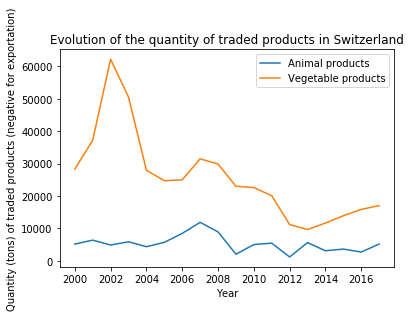

In [175]:
total_animal_product = swiss_animal_trade.groupby(level=1).sum()['Net Quantity']
total_vegetable_product = swiss_vegetable_trade.groupby(level=1).sum()['Net Quantity']

fig = plt.figure()
plt.plot(range(2000,2018), total_animal_product, label='Animal products')
plt.plot(range(2000,2018), total_vegetable_product, label='Vegetable products')
# Set x label as integer
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Evolution of the quantity of traded products in Switzerland")
plt.ylabel("Quantity (tons) of traded products (negative for exportation)")
plt.xlabel("Year")
plt.legend()
plt.show()

We can see that switzerland import both animal and vegetable products. The importation of meat products is constant while the importation of vegetable products has decreased from 2002.

### Comparison between belgium and switzerland <a name="comparison_belgium_swiss_trade"></a>
The first comparison is made based on the quantity of importation for animal and vegetable products.

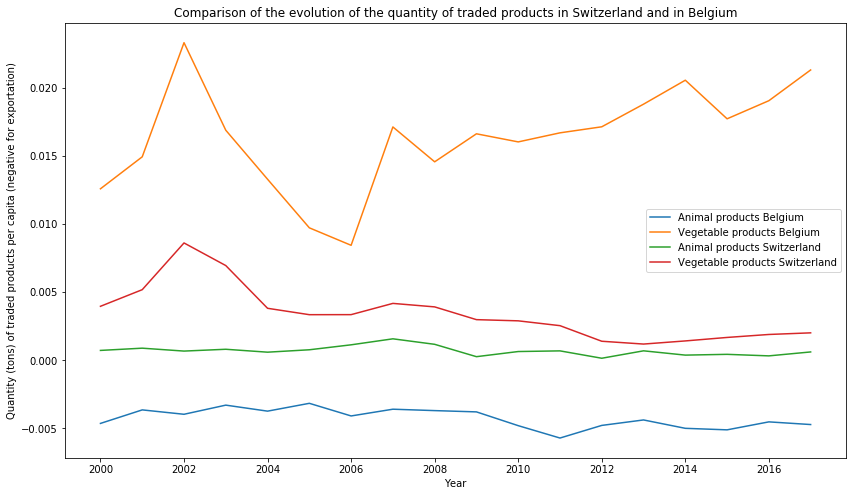

In [184]:
total_animal_product_belgium = []
total_vegetable_product_belgium = []
total_animal_product_switzerland = []
total_vegetable_product_switzerland = []

for year in range(2000, 2018):
    total_animal_product_belgium.append(belgium_animal_trade.xs(year, level=1)['Net Quantity'].sum()/population.loc['Belgium', year] )
    total_vegetable_product_belgium.append(belgium_vegetable_trade.xs(year, level=1)['Net Quantity'].sum()/population.loc['Belgium', year])
    total_animal_product_switzerland.append(swiss_animal_trade.xs(year, level=1)['Net Quantity'].sum()/population.loc['Switzerland', year])
    total_vegetable_product_switzerland.append(swiss_vegetable_trade.xs(year, level=1)['Net Quantity'].sum()/population.loc['Switzerland', year])

fig = plt.figure(figsize=(14,8))
plt.plot(range(2000,2018), total_animal_product_belgium, label='Animal products Belgium')
plt.plot(range(2000,2018), total_vegetable_product_belgium, label='Vegetable products Belgium')
plt.plot(range(2000,2018), total_animal_product_switzerland, label='Animal products Switzerland')
plt.plot(range(2000,2018), total_vegetable_product_switzerland, label='Vegetable products Switzerland')
# Set x label as integer
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Comparison of the evolution of the quantity of traded products in Switzerland and in Belgium")
plt.ylabel("Quantity (tons) of traded products per capita (negative for exportation)")
plt.xlabel("Year")
plt.legend()
plt.show()

We can see that per capita, Belgium exports more animal products while importing much more vegetable product than Switzerland.

### Adding emissions <a name="adding_emissions"></a>
We will first compare direct emissions of the two countries. Then we will add the emission from the country where Belgium and Switzerland import their food. 

We will now join the emission dataframe with the dataframes created in the previous section

In [74]:
swiss_emission = emissions_total.loc['Switzerland']
swiss_emission = swiss_emission[swiss_emission.index >= 2000]
swiss_emission = swiss_emission[swiss_emission.index < 2018]
swiss_emission = pd.merge(swiss_emission, population.loc['Switzerland'], left_index=True, right_index=True)

belgium_emission = emissions_total.loc['Belgium']
belgium_emission = belgium_emission[belgium_emission.index >= 2000]
belgium_emission = belgium_emission[belgium_emission.index < 2018]
belgium_emission = pd.merge(belgium_emission, population.loc['Belgium'], left_index=True, right_index=True)

In [75]:
swiss_emission

,Animal,Vegetal,Sum,Population
Year,,,,
2000,2649.532733,716.156600,3365.689333,7143761.0
2001,2678.005840,740.775333,3418.781173,7179169.0
2002,2650.826100,671.314520,3322.140620,7220377.0
2003,2606.023333,667.345340,3273.368673,7268359.0
2004,2560.370673,682.834440,3243.205113,7323737.0
2005,2580.698253,718.021553,3298.719807,7386816.0
2006,2594.247920,717.066760,3311.314680,7457958.0
2007,2590.539133,696.167327,3286.706460,7536982.0
2008,2638.526960,719.004153,3357.531113,7622821.0


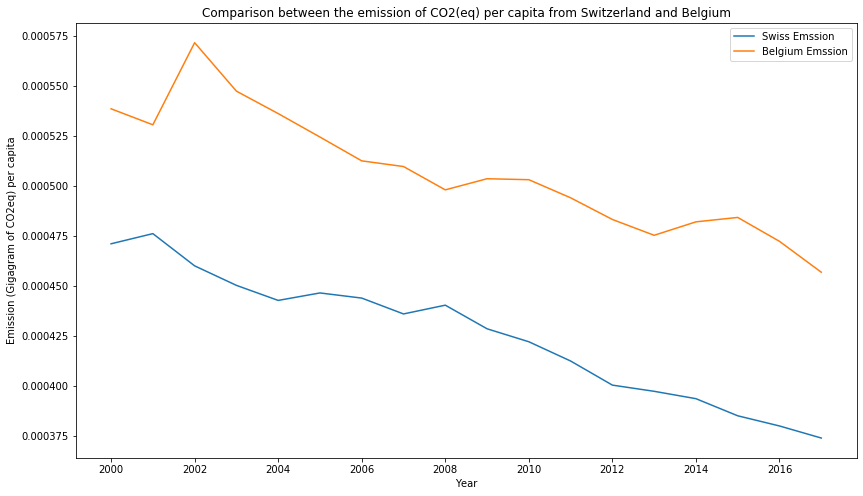

In [186]:
fig = plt.figure(figsize=(14,8))
plt.plot(swiss_emission.index, swiss_emission.Sum/swiss_emission.Population, label='Swiss Emssion')
plt.plot(belgium_emission.index, belgium_emission.Sum/belgium_emission.Population, label='Belgium Emssion')
# Set x label as integer
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Comparison between the emission of CO2(eq) per capita from Switzerland and Belgium")
plt.ylabel("Emission (Gigagram of CO2eq) per capita")
plt.xlabel("Year")
plt.legend()
plt.show()

We see that Belgium emits much more CO2eq per capita than Switerland. But it seems that both country try to reduce their emissions of CO2 eq.

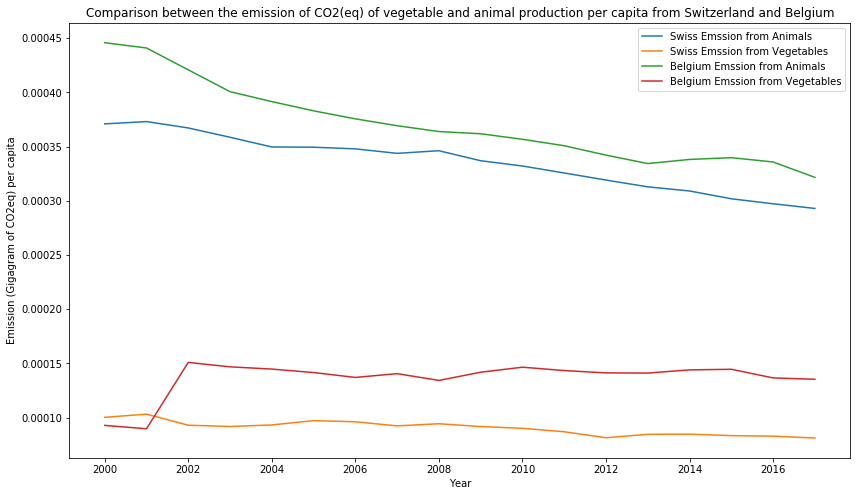

In [187]:
fig = plt.figure(figsize=(14,8))
plt.plot(swiss_emission.index, swiss_emission.Animal/swiss_emission.Population, label='Swiss Emssion from Animals')
plt.plot(swiss_emission.index, swiss_emission.Vegetal/swiss_emission.Population, label='Swiss Emssion from Vegetables')
plt.plot(belgium_emission.index, belgium_emission.Animal/belgium_emission.Population, label='Belgium Emssion from Animals')
plt.plot(belgium_emission.index, belgium_emission.Vegetal/belgium_emission.Population, label='Belgium Emssion from Vegetables')
# Set x label as integer
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Comparison between the emission of CO2(eq) of vegetable and animal production per capita from Switzerland and Belgium")
plt.ylabel("Emission (Gigagram of CO2eq) per capita")
plt.xlabel("Year")
plt.legend()
plt.show()

As seen before the majority of the emission is due to the production of animal product. Moreover the decreasing of the emission in total is due more by the reduction of emission of CO2eq from the production of animal products.

We now add the emission in the previously constructed datasets

In [78]:
def add_emissions(trade, emissions_total, local_emission, type_prod='Animal'):
    trade = pd.merge(trade, emissions_total[type_prod], left_index=True, right_index=True)
    trade = trade.rename(columns={type_prod:'Emission'})
    trade = pd.merge(trade, local_emission[type_prod], left_index=True, right_index=True)
    trade = trade.rename(columns={type_prod:'Local Emission'})
    return trade


belgium_animal_trade = add_emissions(belgium_animal_trade, emissions_total, belgium_emission, type_prod='Animal')
belgium_vegetable_trade = add_emissions(belgium_vegetable_trade, emissions_total, belgium_emission, type_prod='Vegetal')
swiss_animal_trade = add_emissions(swiss_animal_trade, emissions_total, swiss_emission, type_prod='Animal')
swiss_vegetable_trade = add_emissions(swiss_vegetable_trade, emissions_total, swiss_emission, type_prod='Vegetal')

In [79]:
belgium_vegetable_trade

Export Quantity  Import Quantity  Net Quantity    Emission  \
Country     Year                                                               
Afghanistan 2000      8154.500000         0.000000  -8154.500000  713.800800   
            2001      1014.000000         0.000000  -1014.000000  715.276733   
            2002       151.400000         0.000000   -151.400000  857.501927   
            2003       373.000000         0.000000   -373.000000  923.055813   
            2004       710.250000         0.000000   -710.250000  984.950713   
...                           ...              ...           ...         ...   
Zimbabwe    2013        17.750000       297.833333    280.083333  358.793007   
            2014        10.416667       213.000000    202.583333  387.666227   
            2015         9.842105       101.500000     91.657895  337.880247   
            2016        23.052632        69.400000     46.347368  440.885240   
            2017         0.363636       107.600000    107.236364  439.735920   

                  Local Emission  
Country     Year                  
Afghanistan 2000      954.332947  
            2001      925.616827  
            2002     1564.061680  
            2003     1529.692987  
            2004     1517.080980  
...                          ...  
Zimbabwe    2013     1573.578553  
            2014     1616.006653  
            2015     1631.866413  
            2016     1551.146180  
            2017     1545.856740  

[3714 rows x 5 columns]

In [80]:
belgium_animal_trade

Export Quantity  Import Quantity  Net Quantity     Emission  \
Country     Year                                                                
Afghanistan 2003        22.000000              0.0    -22.000000  6119.591000   
            2004         0.000000              0.0      0.000000  6020.478287   
            2005         1.166667              0.0     -1.166667  6175.752553   
            2006        14.000000              0.0    -14.000000  6195.951187   
            2007        25.000000              0.0    -25.000000  6172.708380   
...                           ...              ...           ...          ...   
Zimbabwe    2013         7.000000              0.0     -7.000000  5968.379433   
            2014         2.000000              0.0     -2.000000  4830.453527   
            2015         0.000000             18.0     18.000000  4910.555220   
            2016        82.750000             42.0    -40.750000  5488.609307   
            2017       237.500000             12.0   -225.500000  5491.554960   

                  Local Emission  
Country     Year                  
Afghanistan 2003     4173.804853  
            2004     4102.365353  
            2005     4038.736187  
            2006     3987.877040  
            2007     3949.558033  
...                          ...  
Zimbabwe    2013     3728.815533  
            2014     3793.721913  
            2015     3834.894673  
            2016     3812.155540  
            2017     3672.178413  

[2976 rows x 5 columns]

In [81]:
belgium_animal_trade.to_csv(GENERATED_DATA_PATH+'belgium_animal_trade.csv')
belgium_vegetable_trade.to_csv(GENERATED_DATA_PATH+'belgium_vegetable_trade.csv')
swiss_animal_trade.to_csv(GENERATED_DATA_PATH+'swiss_animal_trade.csv')
swiss_vegetable_trade.to_csv(GENERATED_DATA_PATH+'swiss_vegetable_trade.csv')

## Production <a name="production"></a>
### Introduction
#### Vegetables
To have an estimate of the total amount of vegetables produced by a country on a yearly basis, we will use the 'Production - Crops' data from the FAOSTAT dataset. The vegetable production is split in 10 categories, for which we only take into account the vegetables that are used for food (not *feed*).
These categories are:

1. Cereals: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef01e.htm
2. Roots and Tubers: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef02e.htm
3. Sugar Crops and Sweeteners: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef03e.htm
4. Pulses: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef04e.htm
5. Nuts: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef05e.htm
6. Oil Crops: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef06e.htm
7. Vegetables: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef07e.htm
8. Fruits: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef08e.htm
9. Spices: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef10e.htm
10. Stimulant Crops: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef12e.htm

For these categories, we closely looked at the available documentation to determine the relevant items. Derived products are thus not included.

#### Animals
For the animals we consider four categories:

1. Meat: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef17e.htm
2. Fodder: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef11e.htm
3. Eggs: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef18e.htm#18.6
4. Milk: http://www.fao.org/waicent/faoinfo/economic/faodef/fdef18e.htm#18.1
    
For this the vegetable data is combined with the 'Production - Livestock Primary' dataset. Again, we avoid any overlaps, to get an estimate which is as closely as possible to the actual production within each category.
We now add the information about production 

### Data Preparation <a name="prod_data_prep"></a>

In [82]:
# Load the data
# Production - Crops dataset
production_crops = pd.read_csv(os.path.join(DATA_PATH, "Production_Crops_E_All_Data_(Normalized).csv"), encoding='latin-1')
production_livestock = pd.read_csv(os.path.join(DATA_PATH, "Production_LivestockPrimary_E_All_Data_(Normalized).csv"), encoding="latin-1")

# Load the items for each category
with open(os.path.join(DATA_PATH, "item_classifications.json"), "r") as f:
    classifications = json.load(f)
    
display(production_crops.head())
display(production_livestock.head())

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0.0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900.0,F
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,1977,ha,6000.0,F
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,1978,ha,6000.0,F
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,1979,ha,6000.0,F


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1961,1961,1000 Head,4000.0,F
1,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1962,1962,1000 Head,4400.0,F
2,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1963,1963,1000 Head,4600.0,F
3,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1964,1964,1000 Head,4800.0,F
4,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1965,1965,1000 Head,5200.0,F


In [110]:
# Combine both datasets
production = production_crops.append(production_livestock)

In [111]:
production

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0.0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900.0,F
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,1977,ha,6000.0,F
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,1978,ha,6000.0,F
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,1979,ha,6000.0,F
...,...,...,...,...,...,...,...,...,...,...,...
1120810,5817,Net Food Importing Developing Countries,1807,Sheep and Goat Meat,5510,Production,2013,2013,tonnes,3290297.0,A
1120811,5817,Net Food Importing Developing Countries,1807,Sheep and Goat Meat,5510,Production,2014,2014,tonnes,3272290.0,A
1120812,5817,Net Food Importing Developing Countries,1807,Sheep and Goat Meat,5510,Production,2015,2015,tonnes,3559308.0,A
1120813,5817,Net Food Importing Developing Countries,1807,Sheep and Goat Meat,5510,Production,2016,2016,tonnes,3581011.0,A


In [112]:
# Drop the flag columns for every year
#production = production.drop([f"Y{i}F" for i in range(1961, 2018)], axis=1)

# Transform the dataset to contain seperate columns for the value and the year, instead of seperate columnts for 1961 - 2017
#production = production.melt(id_vars=["Area Code", "Area", "Item", "Item Code", "Element Code", "Element", "Unit"],
                             #value_name="Value",
                             #var_name="Year")



# Clean the year column
#production["Year"] = pd.to_numeric(production["Year"])

# We are only interested in the Production in tonnes TODO: ARE WE? Area harvested/number of animals could be interesting?
production = production.query("`Element` == 'Production'")
# Drop the Element, Element Code, Unit and Area Code columns: aren't of interest anymore
production = production.drop(["Element Code", "Element", "Unit", "Area Code"], axis=1)

production.head()

,Area,Item Code,Item,Year Code,Year,Value,Flag
85,Afghanistan,221,"Almonds, with shell",1975,1975,0.0,F
86,Afghanistan,221,"Almonds, with shell",1976,1976,9800.0,F
87,Afghanistan,221,"Almonds, with shell",1977,1977,9000.0,F
88,Afghanistan,221,"Almonds, with shell",1978,1978,12000.0,F
89,Afghanistan,221,"Almonds, with shell",1979,1979,10500.0,F


In [113]:
# In 2011, Sudan (former) split into two countries: Sudan and South Sudan. We will just assume one united Sudan and merge them.
production.loc[(production['Area']=='Sudan') & (production['Year']>2011), 'Value'] += production.loc[(production['Area']=='South Sudan') & (production['Year']>2011), 'Value'] 
production.loc[(production['Area']=='Sudan (former)', 'Area')] = 'Sudan'
production= production[production['Area'] != 'South Sudan']

In [114]:
# Get a seperate dataframe for each category

def items_to_dataset(items, name):
    """
    Transform the items list to a dataset that contains the sum of the items
    for every country per year, using the production_crops dataset
    """
    # transform the items to integers
    items = list(map(int, items))

    # select the data that contains the items we want to sum together
    selection = production[production["Item Code"].isin(items)]
    
    # drop the item and item code columns: will be summed away
    selection = selection.drop(["Item", "Item Code"], axis=1)
    
    # sum per area, per year
    selection = selection.groupby(["Area", "Year"], as_index=False).sum()
    
    # rename
    return selection.rename({"Value": name}, axis=1)
    
# create the dataset for the vegetable and meat categories
production_aggr = None
for key, val in list(classifications["Plants"].items()) + list(classifications["Animals"].items()):
    if production_aggr is None:
        production_aggr = items_to_dataset(val, key)
    else:
        production_aggr = production_aggr.merge(items_to_dataset(val, key), on=["Area", "Year"], how="outer")

In [115]:
production_aggr.query("`Area` == 'Belgium'").tail()

,Area,Year,Year Code_x,Cereals,Year Code_y,Roots,Year Code_x,Sugar,Year Code_y,Pulses,...,Year Code_x,Spices,Year Code_y,Stimulants,Year Code_x,Milk,Year Code_y,Eggs,Year Code,Meat
941,Belgium,2013,12078.0,3082522.0,2013.0,3428000.0,2013.0,4809300.0,6039.0,4250.0,...,NaN,NaN,NaN,NaN,4026.0,3483230.0,2013.0,173530.0,18117.0,1774712.0
942,Belgium,2014,12084.0,3132461.0,2014.0,4380556.0,2014.0,4790700.0,6042.0,5888.0,...,NaN,NaN,NaN,NaN,4028.0,3701535.0,2014.0,151870.0,18126.0,1814781.0
943,Belgium,2015,12090.0,3134973.0,2015.0,3689994.0,2015.0,4532561.0,6045.0,7127.0,...,NaN,NaN,NaN,NaN,4030.0,4006912.0,2015.0,148025.0,18135.0,1850880.0
944,Belgium,2016,12096.0,2276004.0,2016.0,3402787.0,2016.0,4021110.0,6048.0,6583.0,...,NaN,NaN,NaN,NaN,4032.0,3906695.0,2016.0,154600.0,18144.0,1805539.0
945,Belgium,2017,12102.0,2747443.0,2017.0,4416665.0,2017.0,5941783.0,6051.0,6867.0,...,NaN,NaN,NaN,NaN,4034.0,4058322.0,2017.0,138320.0,18153.0,1794958.0


### Analysis Production Data <a name="prod_data_ana"></a>

#### Getting the per capita production of plant-based and animal-based food products

In [116]:
# Sum together production_aggr columns
production_aggr["PlantSum"] = production_aggr[classifications["Plants"].keys()].sum(axis=1)
production_aggr["AnimalSum"] = production_aggr[classifications["Animals"].keys()].sum(axis=1)
production_products = production_aggr[["Area", "Year", "PlantSum", "AnimalSum"]]

production_products.query("`Area` == 'Belgium'")

,Area,Year,PlantSum,AnimalSum
928,Belgium,2000,13993286.0,5621167.0
929,Belgium,2001,12679702.0,5682021.0
930,Belgium,2002,14393320.0,5489539.0
931,Belgium,2003,13925837.0,5339050.0
932,Belgium,2004,14947000.0,5087773.0
933,Belgium,2005,14040643.0,4950828.0
934,Belgium,2006,13532064.0,4818041.0
935,Belgium,2007,14322823.0,4866195.0
936,Belgium,2008,13280111.0,4699521.0
937,Belgium,2009,14424861.0,4823298.0


We have no data for Belgium from before 2000, so let's focus on 2000 - 2017 for our analysis

In [117]:
production_products = production_products.query("`Year` >= 2000")

Filter the data to only contain countries: aggregate data messes with the distribution

In [118]:
# Load countries
countries = pd.read_csv(DATA_PATH+'country_codes.csv', index_col = 0)['COUNTRY'].to_list()
    
production_products = production_products[production_products["Area"].isin(countries)]

In [119]:
production_products

,Area,Year,PlantSum,AnimalSum
39,Afghanistan,2000,4396343.0,1987038.0
40,Afghanistan,2001,4587725.0,1397953.0
41,Afghanistan,2002,6220400.0,2183851.0
42,Afghanistan,2003,7006306.0,2049510.0
43,Afghanistan,2004,5976105.0,2132752.0
...,...,...,...,...
13613,Greenland,2013,0.0,482.0
13614,Greenland,2014,0.0,529.0
13615,Greenland,2015,0.0,519.0
13616,Greenland,2016,0.0,508.0


Load the population data, to get the per capita production

In [189]:
production_products.merge(population, how="inner", left_on=["Area", "Year"], right_index=True)

,Area,Year,PlantSum,AnimalSum,Population
39,Afghanistan,2000,4396343.0,1987038.0,20779953.0
40,Afghanistan,2001,4587725.0,1397953.0,21606988.0
41,Afghanistan,2002,6220400.0,2183851.0,22600770.0
42,Afghanistan,2003,7006306.0,2049510.0,23680871.0
43,Afghanistan,2004,5976105.0,2132752.0,24726684.0
...,...,...,...,...,...
13613,Greenland,2013,0.0,482.0,56414.0
13614,Greenland,2014,0.0,529.0,56381.0
13615,Greenland,2015,0.0,519.0,56377.0
13616,Greenland,2016,0.0,508.0,56412.0


In [190]:
# Devide the production by the population
production_per_cap = production_products.merge(population, how="inner", left_on=["Area", "Year"], right_index=True)
production_per_cap["PlantSum"] = production_per_cap["PlantSum"] / production_per_cap["Population"]
production_per_cap["AnimalSum"] = production_per_cap["AnimalSum"] / production_per_cap["Population"]
production_per_cap = production_per_cap.drop(["Population"], axis=1)
production_per_cap.head()

,Area,Year,PlantSum,AnimalSum
39,Afghanistan,2000,0.211567,0.095623
40,Afghanistan,2001,0.212326,0.064699
41,Afghanistan,2002,0.275230,0.096627
42,Afghanistan,2003,0.295864,0.086547
43,Afghanistan,2004,0.241686,0.086253


We can now take a look at the data we gathered. By averaging the plant -and animal based production out over the period 2000 - 2017.

In [191]:
avg_production_per_cap = production_per_cap[["Area", "PlantSum", "AnimalSum"]].groupby("Area").mean()
avg_production_per_cap = production_per_cap[["Area", "PlantSum", "AnimalSum"]].groupby("Area").mean()

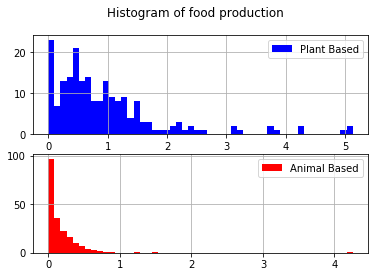

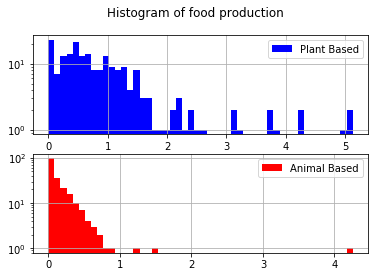

In [192]:
fig, ax = plt.subplots(2)
avg_production_per_cap["PlantSum"].hist(bins=50, ax=ax[0], color="Blue")
fig.suptitle("Histogram of food production")
ax[0].legend(["Plant Based"])
avg_production_per_cap["AnimalSum"].hist(bins=50, ax=ax[1], color="Red")
ax[1].legend(["Animal Based"])
plt.show()
fig, ax = plt.subplots(2)
avg_production_per_cap["PlantSum"].hist(bins=50, ax=ax[0], color="Blue")
fig.suptitle("Histogram of food production")
ax[0].legend(["Plant Based"])
ax[0].set_yscale("log")
avg_production_per_cap["AnimalSum"].hist(bins=50, ax=ax[1], color="Red")
ax[1].legend(["Animal Based"])
ax[1].set_yscale("log")
plt.show()

Based on the previous plots it appears to be that the per capita production of animal-based food products has an exponential distributions, however with one clear outlier. We can check which country this is.

In [193]:
outlier = avg_production_per_cap["AnimalSum"].idxmax()
outlier

'New Zealand'

This outlier actually makes sense, New Zealand is famous for its agriculture. New Zealands agriculture is still good for 2/3 of all exported goods. Taking a look at what this animal based production consists off, should give us a better idea of why we have this outlier:

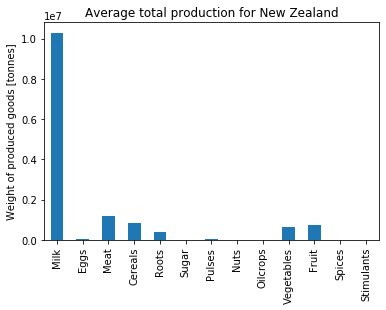

In [200]:
fig, ax = plt.subplots()
production_aggr.query(f"`Area` == '{outlier}'").mean()[list(classifications["Animals"].keys()) + list(classifications["Plants"].keys())].plot.bar()
plt.title("Average total production for New Zealand")
plt.ylabel("Weight of produced goods [tonnes]")
#ax.set_yscale('log')
plt.show()

The outlier can clearly be explained by the huge amount of milk that is produced in New Zealand.

If we go back to the previous histograms, and take a look at the distribution of the plant-based food products, this appears to have some multimodal distribution, with two major modes at ~0.5 tonnes/cap and 1 tonnes/cap.

Something that also jumps into the eye when looking at both distributions, is that there are a lot of very small values for both the animal -and plant based distributions. This, at least visually, seems off. This was however kind of expected because of the way we collect the aggregates. Not every good is produced by every country, so most of the time a missing value indicates that the good is not produced in that country. However this also means the 'real' missing values, the ones that don't fit the actual distribution, are also set to zero. This is for example the case for ALL goods for Belgium until 2000, that was why we took the average from 2000 - 2017

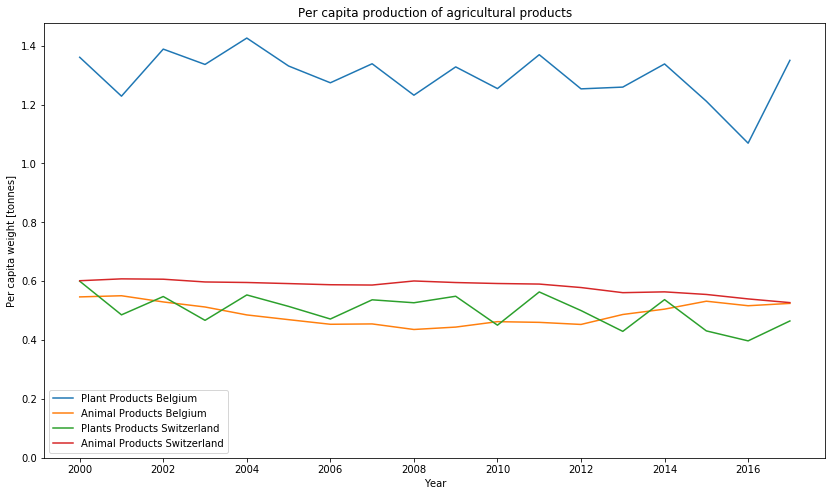

In [201]:
b = production_per_cap.query("`Area` == 'Belgium'")
s = production_per_cap.query("`Area` == 'Switzerland'")
fig = plt.figure(figsize=(14,8))
plt.plot(b["Year"], b["PlantSum"], label="Plant Products Belgium")
plt.plot(b["Year"], b["AnimalSum"], label="Animal Products Belgium")
plt.plot(s["Year"], s["PlantSum"], label="Plants Products Switzerland")
plt.plot(s["Year"], s["AnimalSum"], label="Animal Products Switzerland")
# Set x label as integer
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Year")
plt.ylabel("Per capita weight [tonnes]")
plt.title("Per capita production of agricultural products")
plt.ylim(0, None)
plt.show()

From the plots above we can see that the per capita production stayed pretty much the same over the last couple of years. The think that does stand out is that the plant-based food production in Belgium is way higher than in Switzerland, and than the animal-based food production in both countries. This is actually not that strange if we recall the histograms plotted above. There we could see that the animal-based production values lie closer together, and closer to zero than the plant-based production values. Apperently Belgiums plant-based production is in the 'second mode' of the plant-based production distribution, while switzerland is in the 'first mode'.

## Combining all results <a name="combining"></a>

In [202]:
production = production_aggr
production = production.rename(columns={'Area':'Country'})
production = production[production['Year'] >= 2000]
production = production.set_index(['Country', 'Year'])
production.head()

Year Code_x    Cereals  Year Code_y     Roots  Year Code_x  \
Country     Year                                                               
Afghanistan 2000      10000.0  1940000.0       2000.0  235000.0       6000.0   
            2001      10005.0  2108000.0       2001.0  235000.0       6003.0   
            2002      10010.0  3737000.0       2002.0  230000.0       6006.0   
            2003      10015.0  4381000.0       2003.0  350000.0       6009.0   
            2004      10020.0  3560000.0       2004.0  300000.0       6012.0   

                    Sugar  Year Code_y   Pulses  Year Code_x     Nuts  ...  \
Country     Year                                                       ...   
Afghanistan 2000  42634.0       2000.0  47015.0       8000.0  20800.0  ...   
            2001  42515.0       2001.0  47329.0       8004.0  23800.0  ...   
            2002  42512.0       2002.0  47585.0       8008.0  20574.0  ...   
            2003  64380.0       2003.0  42100.0       8012.0  20900.0  ...   
            2004  68300.0       2004.0  42000.0       8016.0  21945.0  ...   

                  Year Code_y  Stimulants  Year Code_x       Milk  \
Country     Year                                                    
Afghanistan 2000          NaN         NaN       8000.0  1651243.0   
            2001          NaN         NaN       8004.0  1106110.0   
            2002          NaN         NaN       8008.0  1862800.0   
            2003          NaN         NaN       8012.0  1734520.0   
            2004          NaN         NaN       8016.0  1792375.0   

                  Year Code_y     Eggs  Year Code      Meat   PlantSum  \
Country     Year                                                         
Afghanistan 2000       2000.0  15010.0    12000.0  320785.0  4396343.0   
            2001       2001.0  13100.0    12006.0  278743.0  4587725.0   
            2002       2002.0  16730.0    12012.0  304321.0  6220400.0   
            2003       2003.0  16371.0    12018.0  298619.0  7006306.0   
            2004       2004.0  17400.0    12024.0  322977.0  5976105.0   

                  AnimalSum  
Country     Year             
Afghanistan 2000  1987038.0  
            2001  1397953.0  
            2002  2183851.0  
            2003  2049510.0  
            2004  2132752.0  

[5 rows x 28 columns]

In [203]:
vegetal_col = ['Cereals', 'Roots', 'Sugar', 'Pulses', 'Nuts', 'Oilcrops', 'Vegetables', 'Fruit', 'Spices', 'Stimulants']
animal_col = ['Milk', 'Eggs', 'Meat']
production_animal = pd.DataFrame(production[animal_col].sum(axis=1), columns=['Production'])
production_vegetal = pd.DataFrame(production[vegetal_col].sum(axis=1), columns=['Production'])
# We drop data for which the production is 0
production_animal = production_animal.drop(index=production_animal[production_animal['Production'] == 0].index)
production_vegetal = production_vegetal.drop(index=production_vegetal[production_vegetal['Production'] == 0].index)

In [204]:
belgium_animal_trade = pd.read_csv(GENERATED_DATA_PATH+'belgium_animal_trade.csv', index_col=[0,1])
belgium_vegetable_trade = pd.read_csv(GENERATED_DATA_PATH+'belgium_vegetable_trade.csv', index_col=[0,1])
swiss_animal_trade = pd.read_csv(GENERATED_DATA_PATH+'swiss_animal_trade.csv', index_col=[0,1])
swiss_vegetable_trade = pd.read_csv(GENERATED_DATA_PATH+'swiss_vegetable_trade.csv', index_col=[0,1])

In [205]:
def create_emissions_correction(trade, production, country):
    trade = pd.merge(trade, production, left_index=True, right_index=True).sort_index()
    local_production = production.loc[country]
    local_production = local_production.rename(columns={'Production' : 'Local Production'})
    trade = pd.merge(trade, local_production, left_index=True, right_index=True)
    trade['% of production'] = trade['Import Quantity'] / trade['Production']
    trade['% of local production'] = trade['Export Quantity'] / trade['Local Production']
    trade['Emission to add'] = trade['Emission'] * trade['% of production']
    trade['Emission to remove'] = trade['Local Emission'] * trade['% of local production']
    trade['Correction'] = trade['Emission to add'] - trade['Emission to remove']
    correction = trade.groupby(level=1).sum()['Correction']
    return correction

In [206]:
def correct_emissions(emissions, trade, production, country, product='Animal'):
    col_correction = product+' Correction'
    emissions[col_correction] = create_emissions_correction(trade, production, country)
    return emissions[product] + emissions[col_correction]    

In [207]:
belgium_emission_corrected = pd.DataFrame()
belgium_emission_corrected['Animal'] = correct_emissions(belgium_emission, belgium_animal_trade, production_animal, 'Belgium')
belgium_emission_corrected['Vegetal'] = correct_emissions(belgium_emission, belgium_vegetable_trade, production_vegetal, 'Belgium')
belgium_emission_corrected['Sum'] = belgium_emission_corrected['Animal'] + belgium_emission_corrected['Vegetal']

swiss_emission_corrected = pd.DataFrame()
swiss_emission_corrected['Animal'] = correct_emissions(swiss_emission, swiss_animal_trade, production_animal, 'Switzerland')
swiss_emission_corrected['Vegetal'] = correct_emissions(swiss_emission, swiss_vegetable_trade, production_vegetal, 'Switzerland')
swiss_emission_corrected['Sum'] = swiss_emission_corrected['Animal'] + swiss_emission_corrected['Vegetal']

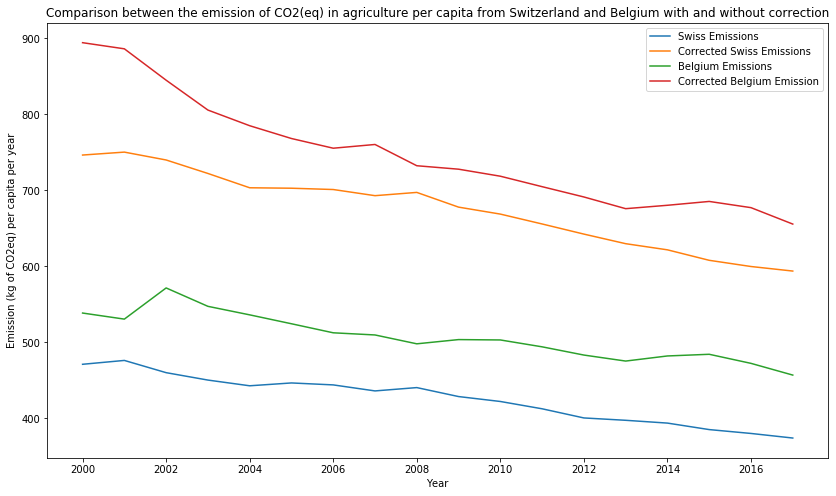

In [208]:
fig = plt.figure(figsize=(14,8))
plt.plot(swiss_emission.index, swiss_emission.Sum/swiss_emission.Population * 1000000, label='Swiss Emissions')
plt.plot(swiss_emission.index, swiss_emission_corrected.Sum/swiss_emission.Population * 1000000, label='Corrected Swiss Emissions')
plt.plot(belgium_emission.index, belgium_emission.Sum/belgium_emission.Population * 1000000, label='Belgium Emissions')
plt.plot(belgium_emission.index, belgium_emission_corrected.Sum/belgium_emission.Population * 1000000, label='Corrected Belgium Emission')
# Set x label as integer
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Comparison between the emission of CO2(eq) in agriculture per capita from Switzerland and Belgium with and without correction")
plt.ylabel("Emission (kg of CO2eq) per capita per year")
plt.xlabel("Year")
plt.legend()
plt.show()

## Conclusion <a name="conclusion"></a>

In this notebook, next to cleaning and structuring our datasets, we already reached some valuable results. 
First, as expected, agriculture (and more specifically animal products) have a big impact on GHG emissions worldwide. Next, we pinpointed the countries with the highest emission per capita. Furthermore, we saw that taking into account the import and export of countries, provides a more honest representation of the real GHG emission for countries.

Our final goal is to have a data story that has the following chapters :
* Importance of agriculture in global greenhouse gases emissions and its evolution over the years.
* Importance of vegetal and animal products into agriculture emissions. 
* Emissions of agriculture in each country
* Deeper study on Belgium and Switzerland :
  * Emissions of Belgium and Switzerland
  * Adding the impact of the trading of food goods
  * Adding the impact of the transport of traded food
  * Real emissions of Belgium and Switzerland
* Real emissions of other Regions/ Countries
* Interactive map of real emissions per country

The next steps include: 
* Add data of transport (1/12):
  * Find a dataset of emission for transport between countries
  * Incorporate this data in ours
  * Study it's influence on emissions for food products of Belgium and Switzerland
  
* Add the emissions from energy use in aggriculture (1/12) :
  * Add emissions from energy from dataset 'Emissions_Agriculture_Energy_E_All_Data_(Norm)'
  * Find a way to divide those emissions into vegetal and animal products
  * Add those emissions to the already existing dataframes and study its impact


* Get a better estimate of how much CO2 the production caused (5/12)
  * Currently 1kg of Milk, and 1kg of Meat are treated equally (they are simply added together)
  * Find a better way of combining these subcategories, perhaps buy researching how much CO2 each
    subcategory emits and using a weighted sum
  * Have a look at the amount of vegetal products that are actually used for cattle breeding.


* Create visulalisation (08/12):
  * Create interactive maps for the direct emissions of each country
  * Create map for the quantity of imported/exported product to/from Belgium and Switzerland
  * Show the evolution of emission with and without correction


* Generalize the approach for other countries (11/12)
  * Use the same approach as for Belgium and Switzerland but in a more systematic ways on other countries/regions
  * Use that approach to compare countries/regions with our base case
  * Produce a map containing the REAL emissions of each country for food


* Create the website for the datastory (15/12):
  * Set up the website
  * Write all the text
  * Add the visualisations


* Last review (20/12):
  * Finalize the data story
  * Clean the notebook

# Final

## Creating maps
We create maps using plotly ant the tutorial [here](https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu)

In [ ]:
def create_map(data, title, main_col, year_begin=2000, mid=0):
    """
    Attention !
    Data is a pandas dataframe
    It has to contain fields: 'Year', 'Country' and 'Text'
    """
    # Add Country code
    country_codes = pd.read_csv(DATA_PATH+'country_codes.csv', index_col=0)
    data = pd.merge(data, country_codes, left_on='Country', right_on='COUNTRY')
    
    zmin = data[main_col].astype(float).min()
    zmax = data[main_col].astype(float).max()
    
    data_slider = []
    for year in data.Year.unique():
        # Select the year (and remove DC for now)
        data_year = data[data['Year']== year]

        if mid == 0:
            colorscale = 'RdBu'
        else:
            colorscale = 'magma'
        
        # Sreate the dictionary with the data for the current year
        data_one_year = dict(
                            type='choropleth', # type of map-plot
                            colorscale = colorscale,
                            autocolorscale = False,
                            reversescale=True,
                            zmin = zmin,
                            zmax = zmax,
                            zmid=mid,
                            locations = data_year['CODE'], # the column with the state
                            z = data_year[main_col].astype(float), # the variable I want to color-code
                            text = data_year['text'], # hover text
                            marker = dict(     # for the lines separating states
                                        line = dict (
                                                  color = 'rgb(255,255,255)', 
                                                  width = 2) ),               
                            colorbar = dict(
                                        title = 'Emission')
                            )

        data_slider.append(data_one_year)  # Add the dictionary to the list of dictionaries for the slider

    ##  Create the steps for the slider
    steps = []

    for i in range(len(data_slider)):
        step = dict(method='restyle',
                    args=['visible', [False] * len(data_slider)],
                    label='Year {}'.format(i + year_begin)) # label to be displayed for each step (year)
        step['args'][1][i] = True
        steps.append(step)


    ##  Create the 'sliders' object from the 'steps' 
    sliders = [dict(active=len(data_slider)-1, pad={"t": 1}, steps=steps)]
    
    # Set up the layout (including slider option)
    layout = dict(title=title, sliders=sliders)

    # Create the figure object:
    fig = dict(data=data_slider, layout=layout) 

    # Save the html file
    filename = title.lower().replace(' ','_')
    offline.plot(fig, auto_open=False, filename=RESULT_PATH+'maps/'+filename+'.html', validate=True)

In [ ]:
# Example of preprocessing data before creating a map

data = pd.read_csv(GENERATED_DATA_PATH+'emissions_total.csv')
data = pd.merge(data, population.reset_index(), left_on=['Country', 'Year'], right_on=['Country', 'Year'])
data = data.drop(data[data['Country'] == 'Falkland Islands (Malvinas)'].index)

data_str = pd.DataFrame()
for col in data.columns:
    if col not in ['Country', 'Year']:
        data[col] /= data['Population']
        data[col] *= 1000 # tons of CO2eq per year per capita
        data[col] = data[col].round(2)
    data_str[col] = data[col].astype(str)

# Create the text for mouse-hover for each state, for the current year    
data_str['text'] = data_str['Country']+' <br> Animal: '+data_str['Animal']+' <br> Vegetal: '+data_str['Vegetal']

create_map(data_str, 'Emissions due to agriculture (tons of CO2eq per capita)', 'Sum', year_begin=1961, mid=None)
